
#### Please run all the cells before you proceed. 



***
# <u><font color=blue>NOTEBOOK'S AIM</font><u> : 
## *Find price-dislocated stocks in SP500 using data from Marketbeats.com and Zacks.com* 
***

## *Data webscraped or collected :*
- ## [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) : *List of all current 500 stocks in SP500.*
- ## [Marketbeat](https://www.investopedia.com/terms/l/leveraged-etf.asp) : *Analyst price targets history in recent times(2-3years) for each stock.*
- ## [Zacks](zacks.com) : *Zacks proprietary ratings with expected EPS growth and dividend yield for each stock.*

### *Webscraping is expected to take around 15 minutes. Please wait for it to complete before you proceed with analysis*
    
<br>
<br>

In [1]:
%%capture
# Already installed libraries on mybinder at configuration stage
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install pandas-datareader
#!pip install yfinance
#!pip install ipywidgets

# To be installed libraries at runtime 
!pip install matplotlib==3.2.0
!pip install selenium
!pip install beautifulsoup4
!pip install webdriver-manager

In [2]:
%reset -f
#importing all libraries 
import numpy as np; 
import matplotlib ; import matplotlib.pyplot as plt; from matplotlib import cm
import pandas as pd; import pandas_datareader.data as pd_datareader;
import datetime; 
import yfinance as yf; 
import ipywidgets as widgets
import requests ; from bs4 import BeautifulSoup ; 
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

from io import StringIO
from IPython.display import display, HTML, Markdown, clear_output, Image; import IPython
import time; import random
import ipywidgets as widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

%matplotlib inline

## *It is well documented that sell-side analysts' ability to predict the stock price of a company [leaves a lot](https://www.nasdaq.com/articles/should-investors-use-sell-side-price-targets-and-if-so-how-2021-03-01) to desire. Most of the drawbacks in analyst's prediction is their prejudice to a business, their inaccurate prediction of the business model's effectivess and general macro trends.* 

## *Considering the fact that the analysts are still one of the most informed group, their consensus price target still could help us if we consider only stocks that have had high correlation with consensus price targets historically.*

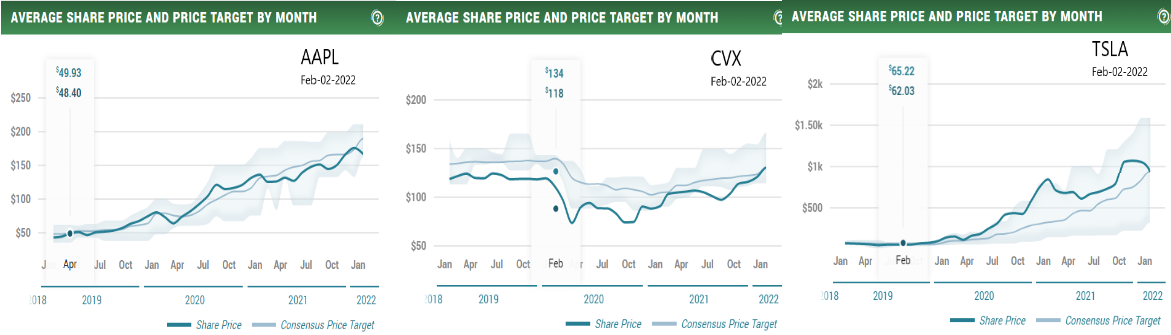

## *As you can see above, Not all stocks have great correlation with consensus price targets.*

## *Well known business with long history and growth like Apple have high correlation with analyst price targets. Mature companies like Chevron with minimum growth ahead tend to always underperform analyst expectations. But they still tend to have some correlation with analyst's price target. Companies with explosive growth ahead like Tesla tend to outperform ahead of analyst's expectations.*

## *So, that brings us to the premise of this project.*

## *Since some companies trade at consistent consensus upside although different (positive incase of CVX, neutral incase of AAPL, negative incase of TSLA), we can compare it to historical value to detect the price dislocations.*

## *Ofcourse, there are always reasons for a business to underperform more than historically. So, inorder to avoid faltering businesses, we also look at the zacks.com ratings and future EPS (Earnings Per Share) of a stock. Zacks.com rates a company's fundamentals, technicals and give them ratings from A-F on their Value, Growth and Momentum. They also provide overall rating of 1(Strong Buy), 2(Buy), 3(Hold), 4(Sell), 5(Strong Sell).*

## *This way we can filter stocks that are trading undervalued based on their history with analyst price targets but good fundamentals or technicals based on zacks.com data.* 

 

In [3]:
#Function to import list of SP500 companies from wikipedia page 
def SP500_List_Wiki_table():
    all_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    SP500_List = all_tables[0]['Symbol'].values.tolist()
    return SP500_List

In [68]:
#Function to get price target information from marketbeat.com
def PriceTargetHistory_Marketbeat(ticker):
    url_NASDAQ = 'https://www.marketbeat.com/scripts/charts/PriceTargetCSV.ashx?prefix=NASDAQ&Symbol='+ticker
    url_NYSE = 'https://www.marketbeat.com/scripts/charts/PriceTargetCSV.ashx?prefix=NYSE&Symbol='+ticker
    url_AMEX = 'https://www.marketbeat.com/scripts/charts/PriceTargetCSV.ashx?prefix=NYSE&Symbol='+ticker
    try : 
        response = requests.get(url_NASDAQ)
        PT_history = pd.read_csv(StringIO(response.text))
    except : 
        try : 
            response = requests.get(url_NYSE)
            PT_history = pd.read_csv(StringIO(response.text))
        except : 
            try : 
                response = requests.get(url_AMEX)
                PT_history = pd.read_csv(StringIO(response.text))
            except : 
                print('File import error for ' + ticker)
                PT_history = 0
    PT_history.drop(['Currency'],axis = 1, inplace=True)
    PT_history.drop(['Unnamed: 6'],axis = 1, inplace=True)
    PT_history['upside_min'] = 100*(PT_history['MinPriceTarget']-PT_history['SharePrice'])/PT_history['SharePrice']
    PT_history['upside_max'] = 100*(PT_history['MaxPriceTarget']-PT_history['SharePrice'])/PT_history['SharePrice']
    PT_history['upside_consensus'] = 100*(PT_history['ConsensusPriceTarget']-PT_history['SharePrice'])/PT_history['SharePrice']   
    return PT_history

#Function to get analyst rating information from marketbeat.com
def AnalystRatingHistory_Marketbeat(ticker):
    url_NASDAQ = 'https://www.marketbeat.com/scripts/charts/AnalystRatingCSV.ashx?prefix=NASDAQ&Symbol='+ticker
    url_NYSE = 'https://www.marketbeat.com/scripts/charts/AnalystRatingCSV.ashx?prefix=NYSE&Symbol='+ticker
    url_AMEX = 'https://www.marketbeat.com/scripts/charts/AnalystRatingCSV.ashx?prefix=NYSE&Symbol='+ticker
    try : 
        response = requests.get(url_NASDAQ)
        Rating_history = pd.read_csv(StringIO(response.text))
    except : 
        try : 
            response = requests.get(url_NYSE)
            Rating_history = pd.read_csv(StringIO(response.text))
        except : 
            try : 
                response = requests.get(url_AMEX)
                Rating_history = pd.read_csv(StringIO(response.text))
            except : 
                print('File import error for ' + ticker)
                Rating_history = 0                
    return Rating_history

#Function to get earnings information from marketbeat.com
def EarningsHistory_Marketbeat(ticker):
    url_NASDAQ = 'https://www.marketbeat.com/scripts/charts/EarningsEstimateCSV.ashx?prefix=NASDAQ&Symbol='+ticker
    url_NYSE = 'https://www.marketbeat.com/scripts/charts/EarningsEstimateCSV.ashx?prefix=NYSE&Symbol='+ticker
    url_AMEX = 'https://www.marketbeat.com/scripts/charts/EarningsEstimateCSV.ashx?prefix=NYSE&Symbol='+ticker
    try : 
        response = requests.get(url_NASDAQ)
        Earnings_history = pd.read_csv(StringIO(response.text))
    except : 
        try : 
            response = requests.get(url_NYSE)
            Earnings_history = pd.read_csv(StringIO(response.text))
        except : 
            try : 
                response = requests.get(url_AMEX)
                Earnings_history = pd.read_csv(StringIO(response.text))
            except : 
                print('File import error for ' + ticker)
                Earnings_history = 0                
    return Earnings_history

#Function to get earnings information from marketbeat.com
def RevenueHistory_Marketbeat(ticker):
    url_NASDAQ = 'https://www.marketbeat.com/scripts/charts/EarningsRevenueCSV.ashx?prefix=NASDAQ&Symbol='+ticker
    url_NYSE = 'https://www.marketbeat.com/scripts/charts/EarningsRevenueCSV.ashx?prefix=NYSE&Symbol='+ticker
    url_AMEX = 'https://www.marketbeat.com/scripts/charts/EarningsRevenueCSV.ashx?prefix=NYSE&Symbol='+ticker
    try : 
        response = requests.get(url_NASDAQ)
        Revenue_history = pd.read_csv(StringIO(response.text))
    except : 
        try : 
            response = requests.get(url_NYSE)
            Revenue_history = pd.read_csv(StringIO(response.text))
        except : 
            try : 
                response = requests.get(url_AMEX)
                Revenue_history = pd.read_csv(StringIO(response.text))
            except : 
                print('File import error for ' + ticker)
                Revenue_history = 0                
    return Revenue_history

# Function to get data from Zacks.com
def Ratings_Zacks(ticker, browser):
    url = 'https://www.zacks.com/stock/quote/'+ticker

    #from selenium import webdriver
    #browser = webdriver.Chrome(ChromeDriverManager().install())
    
    #from selenium.webdriver.chrome.options import Options
    #chrome_options = Options()
    #chrome_options.add_argument("--headless")
    #driver = webdriver.Chrome(executable_path="./chromedriver", options=chrome_options)
    
    browser.get(url)
    soup = BeautifulSoup(browser.page_source, "lxml")
    #browser.close()
    stock_data_zacks = {}
    stock_data_zacks['TickerZacks'] = ticker
    stock_data_zacks['CurrentPrice']=float(soup.find("p", class_='last_price').text.replace(',','').strip('$').split()[0])
    stock_data_zacks['ZacksRank']=int(soup.find("p", class_='rank_view').text.split('-')[0].strip())
    stock_data_zacks['ValueRating']=soup.select('p.rank_view > span.composite_val')[0].text
    stock_data_zacks['GrowthRating']=soup.select('p.rank_view > span.composite_val')[1].text
    stock_data_zacks['MomentumRating']=soup.select('p.rank_view > span.composite_val')[2].text
    stock_data_zacks['VGMRating']=soup.select('p.rank_view > span.composite_val')[3].text
    earnings_data = soup.find('section', id='stock_key_earnings').find_all('dd')
    stock_data_zacks['ExpEPSgrowth']=float(earnings_data[6].text.split('%')[0])
    stock_data_zacks['EarningsESP']=float(earnings_data[0].text.split('%')[0])
    stock_activity = soup.find('section', id='stock_activity').find_all('dl')
    stock_data_zacks['Dividend']=float(stock_activity[7].text.split(' ')[-1].split('%')[0])    
    return stock_data_zacks

# Function to eliminate companies that do not have valid or sufficient data
def Trim_SP500 (SP500_ticker_data, c_zacks_rank, c_MinNumRatings, c_consistency, c_vgm, c_v, c_g, c_m) : 
    
    SP500_valid_data = SP500_ticker_data.copy()
    
    Zacks_Rank_dict = {'Strong Buy':1.0, 'Buy':2.0, 'Hold':3.0, 'Sell':4.0, 'Strong Sell':5.0}
    c_zacks_ranknum = []
    for i in c_zacks_rank :
        c_zacks_ranknum.append(Zacks_Rank_dict.get(i))
    print(c_zacks_rank)
    print(c_zacks_ranknum)

    SP500_valid_data.drop(SP500_valid_data[~SP500_valid_data['ZacksRank'].isin(c_zacks_ranknum)].index, inplace=True)
    SP500_valid_data.drop(SP500_valid_data[~SP500_valid_data['VGMRating'].isin(c_vgm)].index, inplace=True)
    SP500_valid_data.drop(SP500_valid_data[~SP500_valid_data['ValueRating'].isin(c_v)].index, inplace=True)
    SP500_valid_data.drop(SP500_valid_data[~SP500_valid_data['GrowthRating'].isin(c_g)].index, inplace=True)
    SP500_valid_data.drop(SP500_valid_data[~SP500_valid_data['MomentumRating'].isin(c_m)].index, inplace=True)

    SP500_valid_data.dropna(inplace=True) # dropping all rows with NaN values
    SP500_valid_data.drop(SP500_valid_data[SP500_valid_data['AvgNumRatings']<c_MinNumRatings].index, inplace=True)
    SP500_valid_data.drop(SP500_valid_data[SP500_valid_data['StdConsensusUpside']>c_consistency].index, inplace=True)
    SP500_valid_data.reset_index(drop=True, inplace=True)
    print('Total tickers with valid data: ',len(SP500_valid_data))
    return SP500_valid_data

#Function to plot bubble plot for valid SP500 data
def BubblePlotFunction(SP500_valid_data,c_zacks_rank) :
    output.clear_output()
    clear_output()
    with output :
        
        fig, ax = plt.subplots(figsize=(15,10))

        x = SP500_valid_data.ExpEPSgrowth ; y = SP500_valid_data.PTMeanReversionUpside;
        ConsensusUpside_consistency = 100/SP500_valid_data['StdConsensusUpside']
        
        Zacks_RankColor_dict = {'Strong Buy':"darkgreen", 'Buy':"greenyellow", 'Hold':"yellow", 'Sell':"sandybrown", 'Strong Sell':"firebrick"}
        c_cmap = []
        for i in c_zacks_rank :
            c_cmap.append(Zacks_RankColor_dict.get(i))
        BubblePlot = ax.scatter(data = SP500_valid_data,x='ExpEPSgrowth',y='PTMeanReversionUpside', alpha = 0.8, 
                                    s = (ConsensusUpside_consistency)**3, c = SP500_valid_data.ZacksRank, cmap = ListedColormap(c_cmap))


        marker1 = Line2D(range(1), range(1),  marker='o', markerfacecolor="darkgreen",  markersize=10,linewidth=0 )
        marker2 = Line2D(range(1), range(1),  marker='o', markerfacecolor="lightgreen", markersize=10,linewidth=0 )
        marker3 = Line2D(range(1), range(1),  marker='o', markerfacecolor="yellow",     markersize=10,linewidth=0 )
        marker4 = Line2D(range(1), range(1),  marker='o', markerfacecolor="sandybrown", markersize=10,linewidth=0 )
        marker5 = Line2D(range(1), range(1),  marker='o', markerfacecolor="firebrick",  markersize=10,linewidth=0 )

        plt.legend((marker1,marker2,marker3,marker4,marker5),('Strong Buy','Buy', 'Hold', 'Sell', 'Strong Sell'), title = 'Zacks Rank',title_fontsize='x-large',loc='upper right')

        ax.text(0.96, 0.09, 'DY : Dividend Yield(%)',
                verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='royalblue', fontsize=15)
        
        ax.text(0.96, 0.05, 'Bubble size indicates ConsensusUpside consistency (inverse of deviation)',
                verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='royalblue', fontsize=15)

        ax.text(0.96, 0.01, 'Number of Companies included in the analysis : '+str(SP500_valid_data.shape[0]),
                verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes,color='royalblue', fontsize=15)
        
        for line in range(0,SP500_valid_data.shape[0]):
             ax.text(SP500_valid_data.ExpEPSgrowth[line], SP500_valid_data.PTMeanReversionUpside[line],SP500_valid_data.ticker[line],
                     horizontalalignment='center',verticalalignment='center', size='large', color='black', weight='semibold')

        for line in range(0,SP500_valid_data.shape[0]):
             ax.text(SP500_valid_data.ExpEPSgrowth[line], -1+SP500_valid_data.PTMeanReversionUpside[line],'DY '+str(SP500_valid_data.Dividend[line]),
                     horizontalalignment='center',verticalalignment='top', size='medium', color='black', weight='semibold')
        
        ax.set_xlabel('Expected EPS CAGR % (3-5yr)', fontsize = 20)
        ax.set_ylabel('Upside/downside (%) \n from mean reversion to consensus upside ', fontsize = 25)
        ax.set_title('Upside/downside vs EPS Growth ', fontsize = 30)
        ax.tick_params(axis='both', labelsize=18)
        plt.close()
        display(fig)

In [5]:
SP500_List = SP500_List_Wiki_table()
SP500_tickers = pd.DataFrame(SP500_List); SP500_tickers.columns = ['ticker']; 
TotalNum_SP500 = len(SP500_tickers) # this is not necessarily 500 since some companies have two classes of shares

# Collecting price target and ratings data for all SP500 companies
SP500_ratings = []; SP500_targets = []; SP500_earnings = []; SP500_revenues = [];
for i,row in SP500_tickers.iterrows() :
    ticker = row['ticker']
    print('Running '+str(i+1)+'/'+str(TotalNum_SP500)+' companies')
    
    # Collecting price targets data
    df_targets = PriceTargetHistory_Marketbeat(ticker)
    df_targets.fillna(0,inplace=True) # replacing NaN values with 0
    SP500_targets.append(df_targets)
    
    # Collecting analyst ratings data
    df_ratings = AnalystRatingHistory_Marketbeat(ticker)
    df_ratings.fillna(0,inplace=True) # replacing NaN values with 0
    SP500_ratings.append(df_ratings)
    
    # Collecting earnings data
    df_earnings = EarningsHistory_Marketbeat(ticker)
    df_earnings.fillna(0,inplace=True) # replacing NaN values with 0
    SP500_earnings.append(df_earnings)
    
    # Collecting revenue data
    df_revenues = RevenueHistory_Marketbeat(ticker)
    df_revenues.fillna(0,inplace=True) # replacing NaN values with 0
    SP500_revenues.append(df_revenues)  
    
    clear_output(wait=True)

Running 505/505 companies


In [59]:
SP500_ticker_data = SP500_tickers.copy()
zacks_data = pd.DataFrame()

# Initiating browser for selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument("--headless")
browser = webdriver.Chrome(ChromeDriverManager().install(),options=chrome_options)

for i,row in SP500_ticker_data.iterrows() :
  
    clear_output(wait=True)
    print('Running '+str(i+1)+'/'+str(TotalNum_SP500)+' companies')
    # Using ufinance instead of marketbeat data because it is not updated regularly in CSV file
    ticker = SP500_ticker_data.loc[i,'ticker']  
    try : 
        zacks_data = zacks_data.append(pd.DataFrame.from_dict([Ratings_Zacks(ticker, browser)]))
    except : 
        zacks_data.loc[len(zacks_data.index),:] = np.nan  
        
    #SP500_ticker_data.loc[i,'CurrentPrice'] = yf.Ticker(ticker.replace('-','-')).history().loc[:,"Close"][-1]     
    SP500_ticker_data.loc[i,'AvgMinUpside'] = round(SP500_targets[i]['upside_min'].mean(),2)
    SP500_ticker_data.loc[i,'AvgMaxUpside'] = round(SP500_targets[i]['upside_max'].mean(),2)
    SP500_ticker_data.loc[i,'AvgConsensusUpside'] = round(SP500_targets[i]['upside_consensus'].mean(),2)
    SP500_ticker_data.loc[i,'StdConsensusUpside'] = round(SP500_targets[i]['upside_consensus'].std(),2)
    SP500_ticker_data.loc[i,'AvgNumRatings'] = round(SP500_ratings[i]['TotalRatings'].mean(),0)
    
    #index_wanted = SP500_ticker_data[SP500_ticker_data['ticker'] == ticker].index
    marketbeat_price = SP500_targets[index_wanted.item()]['ConsensusPriceTarget'].iloc[-1]
    zacks_price = zacks_data.CurrentPrice.iloc[i].item()
    
    # Marketbeat data for current price is not reliable. So, using Zacks data instead.    
    '''    
    if not(SP500_targets[i].empty) :
        SP500_ticker_data.loc[i,'CurrentMinUpside'] = round(SP500_targets[i]['upside_min'].values[-1],2)
        SP500_ticker_data.loc[i,'CurrentMaxUpside'] = round(SP500_targets[i]['upside_max'].values[-1],2)
        SP500_ticker_data.loc[i,'CurrentConsensusUpside'] = round(SP500_targets[i]['upside_consensus'].values[-1],2)
        SP500_ticker_data.loc[i,'CurrentNumRatings'] = round(SP500_ratings[i]['TotalRatings'].values[-1],2)
    ''' 
    
    if not(SP500_targets[i].empty) :
        SP500_ticker_data.loc[i,'CurrentMinUpside'] = 100*(SP500_targets[i]['MinPriceTarget'].values[-1]-zacks_price)/zacks_price
        SP500_ticker_data.loc[i,'CurrentMaxUpside'] = 100*(SP500_targets[i]['MaxPriceTarget'].values[-1]-zacks_price)/zacks_price
        SP500_ticker_data.loc[i,'CurrentConsensusUpside'] = 100*(SP500_targets[i]['ConsensusPriceTarget'].values[-1]-zacks_price)/zacks_price  
        SP500_ticker_data.loc[i,'CurrentNumRatings'] = round(SP500_ratings[i]['TotalRatings'].values[-1],2)

browser.close()
SP500_ticker_data['PTMeanReversionUpside'] = SP500_ticker_data['CurrentConsensusUpside'] - SP500_ticker_data['AvgConsensusUpside']
SP500_ticker_data = pd.concat((SP500_ticker_data,zacks_data.reset_index()),axis=1)

Running 505/505 companies


## *Before we proceed to filter the stocks, let us look at the historical consensus upside of SP500 companies and their standard deviation.*

## *As you can see in the graphs below, Lot of stocks trade with 10% average consensus upside and they varied by 5-20% in last 2-3 years (limited by marketbeat.com data)* : 
### 



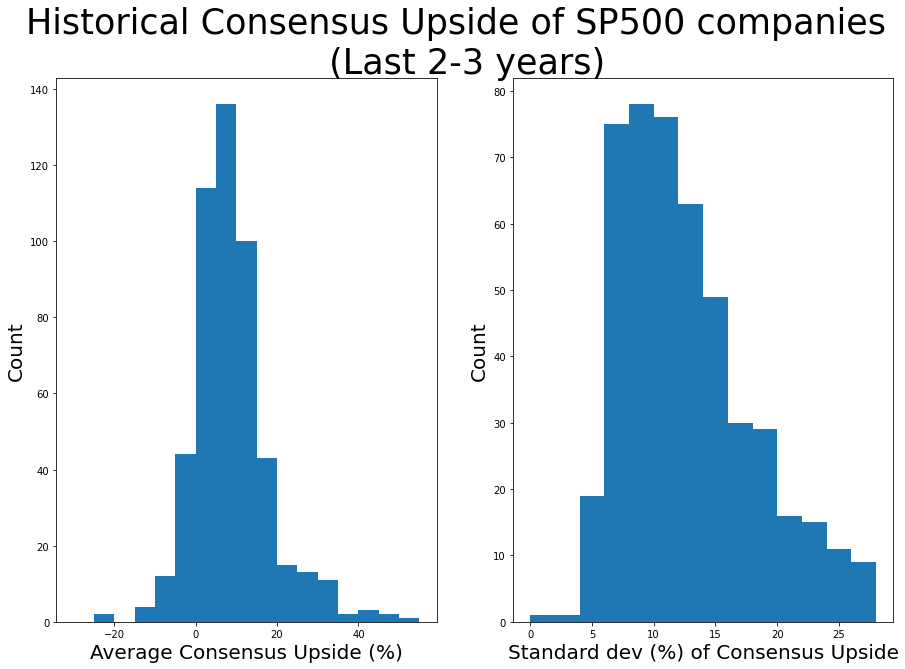

In [60]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))
plt.suptitle('Historical Consensus Upside of SP500 companies \n (Last 2-3 years)', fontsize = 35)
# Average Consensus Upside of an SP500 company
ax1.hist(SP500_ticker_data['AvgConsensusUpside'],bins=np.arange(-30,60,5))
ax1.set_xlabel('Average Consensus Upside (%)', fontsize =20);ax1.set_ylabel('Count', fontsize =20);

# Standard deviation of Consensus Upside of an SP500 company
ax2.hist(SP500_ticker_data['StdConsensusUpside'],bins=np.arange(0,30,2))
ax2.set_xlabel('Standard dev (%) of Consensus Upside', fontsize =20);ax2.set_ylabel('Count', fontsize =20);

display(Markdown('''## *Before we proceed to filter the stocks, let us look at the historical consensus upside of SP500 companies and their standard deviation.*'''))
display(Markdown('''## *As you can see in the graphs below, Lot of stocks trade with 10% average consensus upside and they varied by 5-20% in last 2-3 years (limited by marketbeat.com data)* : 
### \n
'''))

In [61]:
# All parameters needed for interactive widgets (Slicer, Dropdown, SelectMultiple, input box)

Slider_MinNumRatings = widgets.IntSlider(min=3,max=25,step=1, value = 15,description = 'Minimum Number of Analyst Ratings',
                                         style={'description_width': 'initial'}, readout = True,layout = {'width':'600px'},
                                         continuous_update=False)
Zacks_Rank_List = ['Strong Buy', 'Buy', 'Hold', 'Sell', 'Strong Sell']
Consensus_Consistency_list = [10,20,30,40]
Select_zacks_rank = widgets.SelectMultiple(options= Zacks_Rank_List, value=Zacks_Rank_List, description = 'Zacks Rank',
                                         style={'description_width': 'initial'},layout = {'width':'200px'},continuous_update=False)
Dropdown_consensus_consistency = widgets.Dropdown (options= Consensus_Consistency_list, value=10, description = 'Maximum ConsensusUpside average deviation (%)',
                                         style={'description_width': 'initial'},layout = {'width':'400px'},continuous_update=False)
Select_VGM_grade = widgets.SelectMultiple(options=['A','B','C','D','E','F'],value=['A','B','C'],
                                         description='VGM grade',disabled=False)
Select_Value_grade = widgets.SelectMultiple(options=['A','B','C','D','E','F'],value=['A','B','C'],
                                         description='Value grade',disabled=False)
Select_Growth_grade = widgets.SelectMultiple(options=['A','B','C','D','E','F'],value=['A','B','C'],
                                         description='Growth grade',disabled=False)
Select_Momentum_grade = widgets.SelectMultiple(options=['A','B','C','D','E','F'],value=['A','B','C'],
                                         description='Momentum grade',disabled=False)
Text_ticker = widgets.Text(value='MSFT', placeholder='Type Ticker', description='Ticker:',disabled=False)

In [63]:
# Adjusting cell size to fill the output
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

display(Markdown('''## *Now that have an idea about the consistency in consensus upside, Let us go ahead and filter the data.*'''))
display(Select_zacks_rank)
display(Slider_MinNumRatings)
display(Dropdown_consensus_consistency)
display(Markdown('''#### *Remember that lower the deviation allowed, smaller the choice of companies but higher the consistency in consensus upside.*'''))
display(Select_VGM_grade)
display(Select_Value_grade); display(Select_Growth_grade); display(Select_Momentum_grade)
display(Markdown('''## *Once you have chosen the options in the previous widgets, you can go ahead and press the button below to generate final plot.*'''))

# Creating button to run backtesting manually
button = widgets.Button(description="Generate Plot",layout=widgets.Layout(width='30%', height='50px')); 
button.style.font_weight = 'bold'
output = widgets.Output()
display(button,output)

# Function to define the events when run button is clicked
def on_button_clicked(b):
    output.clear_output()
    with output:
        # update input data before running
        c_zacks_rank = Select_zacks_rank.value
        c_MinNumRatings = Slider_MinNumRatings.value
        c_consistency = Dropdown_consensus_consistency.value
        c_vgm = Select_VGM_grade.value 
        c_v = Select_Value_grade.value ; c_g = Select_Growth_grade.value; c_m = Select_Momentum_grade.value;
        SP500_valid_data = Trim_SP500(SP500_ticker_data,c_zacks_rank,c_MinNumRatings, c_consistency, c_vgm, c_v, c_g, c_m)
        if SP500_valid_data.shape[0] <2 :
            print('Not enough valid data. Please widen your options')
            return
        print(f'Number of companies with valid data for analysis : {SP500_valid_data.shape[0]}')    
        BubblePlotFunction(SP500_valid_data,c_zacks_rank)    
        plt.close()
        #display()

button.on_click(on_button_clicked)

display(Markdown('''## *Bigger the bubble size, more reliable the consensus upside is i.e., less deviation historically.*'''))

display(Markdown('''## *If you see too many bubbles, please limit your filter options to decrease the data points.*'''))

display(Markdown('''## *If you are wondering why a certain company was not present in the previous plot, you can choose your ticker and click the button below to look at the company specific data.*'''))

display(Text_ticker)
# Creating button to run backtesting manually
button2 = widgets.Button(description="Specific Company stats",layout=widgets.Layout(width='30%', height='50px')); 
button2.style.font_weight = 'bold'
output2 = widgets.Output()
display(button2,output2)

dict_zacksrank = {'1.0':'StrongBuy','2.0':'Buy','3.0':'Hold','4.0':'Sell','5.0':'StrongSell' }

# Function to define the events when run button is clicked
def on_button2_clicked(b):
    output2.clear_output()
    with output2:
        
        if Text_ticker.value.upper() not in SP500_ticker_data['ticker'].tolist():
            print('Ticker data not available. Please check your ticker entry')
            return
        
        # update input data before running
        c_ticker = Text_ticker.value.upper()
        index_wanted = SP500_ticker_data[SP500_ticker_data['ticker'] == c_ticker].index
        print(f'Chosen ticker : {SP500_ticker_data.iloc[index_wanted].ticker.item()}')
        print(f'Current Price : {SP500_ticker_data.iloc[index_wanted].CurrentPrice.item()}')
        print('\n')
        print(f'Price-AnalystTarget consistency mean reversion upside : {round(SP500_ticker_data.iloc[index_wanted].PTMeanReversionUpside.item(),2)}')
        print(f'Average Number of Analyst Ratings : {SP500_ticker_data.iloc[index_wanted].AvgNumRatings.item()}') 
        print(f'Current Consensus Upside : {round(SP500_ticker_data.iloc[index_wanted].CurrentConsensusUpside.item(),2)} %') 
        print(f'Average Consensus Upside : {SP500_ticker_data.iloc[index_wanted].AvgConsensusUpside.item()} %') 
        print(f'Standard deviation of Consensus Upside : {SP500_ticker_data.iloc[index_wanted].StdConsensusUpside.item()} %') 
        print('\n')
        print(f'Expected EPS growth for next 3-5 years : {SP500_ticker_data.iloc[index_wanted].ExpEPSgrowth.item()} %') 
        print(f'Dividend Yield : {SP500_ticker_data.iloc[index_wanted].Dividend.item()} %') 
        print('\n')
        zacksrank_ticker = SP500_ticker_data.iloc[index_wanted].ZacksRank.item()
        zacksranksignal_ticker = dict_zacksrank.get(str(zacksrank_ticker))
        print(f'ZacksRank : {zacksrank_ticker} ({zacksranksignal_ticker})') 
        print(f'Zacks VGM Rating : {SP500_ticker_data.iloc[index_wanted].VGMRating.item()}') 
        print(f'Zacks Value Rating : {SP500_ticker_data.iloc[index_wanted].ValueRating.item()}') 
        print(f'Zacks Growth Rating : {SP500_ticker_data.iloc[index_wanted].GrowthRating.item()}') 
        print(f'Zacks Momentum Rating : {SP500_ticker_data.iloc[index_wanted].MomentumRating.item()}') 
        #display()

button2.on_click(on_button2_clicked)

## *Now that have an idea about the consistency in consensus upside, Let us go ahead and filter the data.*

SelectMultiple(description='Zacks Rank', index=(0, 1, 2, 3, 4), layout=Layout(width='200px'), options=('Strong…

IntSlider(value=15, continuous_update=False, description='Minimum Number of Analyst Ratings', layout=Layout(wi…

Dropdown(description='Maximum ConsensusUpside average deviation (%)', layout=Layout(width='400px'), options=(1…

#### *Remember that lower the deviation allowed, smaller the choice of companies but higher the consistency in consensus upside.*

SelectMultiple(description='VGM grade', index=(0, 1, 2), options=('A', 'B', 'C', 'D', 'E', 'F'), value=('A', '…

SelectMultiple(description='Value grade', index=(0, 1, 2), options=('A', 'B', 'C', 'D', 'E', 'F'), value=('A',…

SelectMultiple(description='Growth grade', index=(0, 1, 2), options=('A', 'B', 'C', 'D', 'E', 'F'), value=('A'…

SelectMultiple(description='Momentum grade', index=(0, 1, 2), options=('A', 'B', 'C', 'D', 'E', 'F'), value=('…

## *Once you have chosen the options in the previous widgets, you can go ahead and press the button below to generate final plot.*

Button(description='Generate Plot', layout=Layout(height='50px', width='30%'), style=ButtonStyle(font_weight='…

Output()

## *Bigger the bubble size, more reliable the consensus upside is i.e., less deviation historically.*

## *If you see too many bubbles, please limit your filter options to decrease the data points.*

## *If you are wondering why a certain company was not present in the previous plot, you can choose your ticker and click the button below to look at the company specific data.*

Text(value='FB', description='Ticker:', placeholder='Type Ticker')

Button(description='Specific Company stats', layout=Layout(height='50px', width='30%'), style=ButtonStyle(font…

Output()

# THE END

In [10]:
SP500_ticker_data

,ticker,AvgMinUpside,AvgMaxUpside,AvgConsensusUpside,StdConsensusUpside,AvgNumRatings,CurrentMinUpside,CurrentMaxUpside,CurrentConsensusUpside,CurrentNumRatings,...,TickerZacks,CurrentPrice,ZacksRank,ValueRating,GrowthRating,MomentumRating,VGMRating,ExpEPSgrowth,EarningsESP,Dividend
0,MMM,-7.08,13.46,4.82,6.40,11.0,-1.63,15.55,10.22,13.0,...,MMM,160.73,3.0,B,C,C,B,9.50,0.00,3.60
1,AOS,2.71,18.75,2.20,15.55,7.0,31.44,31.44,-0.11,5.0,...,AOS,73.58,3.0,B,A,A,A,9.00,-1.96,1.51
2,ABT,0.18,17.45,5.52,4.76,14.0,10.07,20.44,11.99,13.0,...,ABT,129.71,3.0,C,C,A,B,10.50,0.00,1.44
3,ABBV,2.82,24.08,12.77,10.48,13.0,-9.92,32.91,9.63,13.0,...,ABBV,140.65,3.0,B,A,B,A,2.54,-0.19,4.01
4,ABMD,-0.07,23.45,19.88,31.47,4.0,-6.82,10.12,14.07,3.0,...,ABMD,295.65,3.0,C,B,C,C,20.00,-3.38,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,YUM,-5.88,18.28,3.66,11.62,16.0,13.47,22.39,10.33,16.0,...,YUM,125.27,3.0,C,A,B,B,12.62,0.62,1.60
501,ZBRA,-2.40,14.33,-3.42,15.09,7.0,33.44,33.44,18.11,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,ZBH,-4.99,29.35,13.18,14.08,20.0,1.66,43.47,34.71,19.0,...,ZBH,122.83,4.0,B,C,B,B,8.25,-0.50,0.79
503,ZION,-2.90,111.82,15.49,19.35,16.0,2.78,28.47,2.15,17.0,...,ZION,71.17,1.0,F,F,D,F,17.46,-0.05,2.21


In [31]:
index_wanted = SP500_ticker_data[SP500_ticker_data['ticker'] == ticker].index
SP500_ticker_data.iloc[index_wanted]

,ticker,AvgMinUpside,AvgMaxUpside,AvgConsensusUpside,StdConsensusUpside,AvgNumRatings,CurrentMinUpside,CurrentMaxUpside,CurrentConsensusUpside,CurrentNumRatings,...,TickerZacks,CurrentPrice,ZacksRank,ValueRating,GrowthRating,MomentumRating,VGMRating,ExpEPSgrowth,EarningsESP,Dividend
311,FB,-10.84,36.99,15.48,8.47,38.0,-25.37,40.97,13.72,42.0,...,FB,237.09,3.0,B,B,A,A,19.26,-1.01,0.0


In [54]:
zacks_data.CurrentPrice.iloc[index_wanted].item()

237.09